# 데이터 가공 및 시각화
- 1. 전처리
    - 결측값 처리: 단순대치, 평균 대치, 단순확률 대치 (Hot-deck, nearest neighbor), 다중 대치, knnImputation, centralimputation
    - 클래스불균형: 업샘플링 (SMOTE, Boaderline SMOTE, Adasyn), 다운샘플링
    - **이상값 처리: 극단값 절단, 조정**
    - 변수 변환, 스케일링: 수치형 변수 변환(로그변환, 제곱근변환, 지수변환, 제곱변환, Box-cox 변환, 표준화, 정규화), 범주형 변수 변환(범주형 변수 인코딩, 대규모 범주형 변수처리), 날짜 및 변수 변환,  피쳐스케일링
    - 원핫인코딩(더미변수), 컬럼 트랜스퍼, 구간분할, 이산화, 피쳐선택
- 2. 표본 추출: 단순랜덤 추출법, 계통추출법, 집락추출법, 층화추출법
- 3. 데이터 분할: 구축/검정/시험용, 홀드아웃방법, 교차확인방법 (10 fold 교차분석), 부트스트랩
- 4. 그래프 그리기:
    - 산점도, 막대그래프, 선그래프, 히트맵, 서브플롯, 트리맵, 도넛차트, 버블차트, 히스토그램, 체르노프 페이스, 스타차트, 다차원척도법, 평행좌표계
    - 도식화와 시각화

## 이상값 처리 방법들: Trim, Winsorizing, DBSCAN
이상값을 처리하는 방법들로는 이상값들을 절단(trim)하는 방법, 이상값들을 이상값의 하한값, 상한값으로 변환하는 조정(winsorizing)의 방법이 있음

이상값에 대한 정의는 아래와 같이 여러 가지가 있어서 분석자가 데이터셋의 상황에 맞게 판단해서 선택해야 함
- ESD(Extreme Studentized Deviation): 평균으로부터 3 표준편차 떨어진 값들
- 일반 데이터의 범위를 벗어나는 경우 1: 기하평균-2.5표준편차 < data < 기하평균+2.5표준편차
- 일반 데이터의 범위를 벗어하는 경우 2: Q1-1.5*(IQR; Q3-Q1) < data < Q3+1.5*(IQR; Q3-Q1)
- Boxplot을 통해 이상값으로 o 표기되는 경우
- DBSCAN 클러스터링을 통해 타겟값이 -1이 되는 경우

### 절단(Trim or Truncation): 경계값 너머의 이상값(outlier)들을 제거
IQR*1.5를 계산하여 데이터의 상한값과 하한값을 찾고 그 너머의 값들을 제거하는 방법

데이터프레임객체에 .quantile(백분위수)를 찾고, IQR을 계산하여 상한값(line_up)과 하한값(line_down)을 찾기

quantile(0.25)를 하면 데이터의 25% 지점에 해당하는 1사분위수를 계산할 수 있고,.quantile(0.75)를 하면 데이터의 75% 지점에 해당하는 3사분위를 얻을 수 있음

데이터프레임객체에 .query()를 활용해서 해당 열에서 하한값보다 작거나 상한값보다 큰 아웃라이어값들의 인덱스값을 out_index 변수에 담기

아웃라이어의 인덱스에 해당하는 행은 drop함수를 통해 삭제 했고 그 결과값을 trimmed 객체에 저장

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('/Users/benny/Desktop/datascience/heart.csv', na_values=['','NA',-1,9999])

32.625 407.625 183


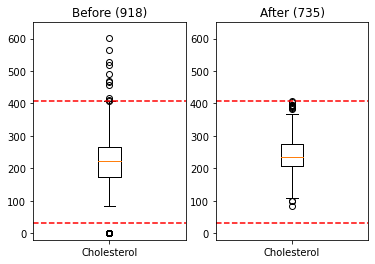

In [10]:
IQR = df['Cholesterol'].quantile(0.75) - df['Cholesterol'].quantile(0.25)

line_down = df['Cholesterol'].quantile(0.25) - IQR * 1.5
line_up = df['Cholesterol'].quantile(0.75) + IQR * 1.5

out_index = df[['Cholesterol']].query("Cholesterol<=@line_down or Cholesterol>=@line_up").index
print(line_down, line_up, len(out_index))

trimmed = df['Cholesterol'].drop(index=out_index, axis=1)

fig, ax = plt.subplots(1, 2)
ax[0].boxplot(df['Cholesterol'], labels=['Cholesterol'])
ax[0].set_title("Before (%s)"%df['Cholesterol'].shape)
ax[0].set_ylim(-20, 650)
ax[0].axhline(line_up, linestyle='--', color='red')
ax[0].axhline(line_down, linestyle='--', color='red')

ax[1].boxplot(trimmed, labels=['Cholesterol'])
ax[1].set_title("After (%s)"%trimmed.shape)
ax[1].set_ylim(-20, 650)
ax[1].axhline(line_up, linestyle='--', color='red')
ax[1].axhline(line_down, linestyle='--', color='red')

plt.show()

### 조정(Winsorizing or clipping): 경계값 너머의 이상값들을 상한값, 하한값으로 치환
조정하려는 데이터 객체에 .clip(하한값, 상한값)이라는 함수를 활용하면 간편하게 조정된 데이터셋을 얻을 수 있음

이상치의 경계인 상한값과 하한값은 분석가가 데이터셋의 상황에 따라 알맞게 정의할 수 있음

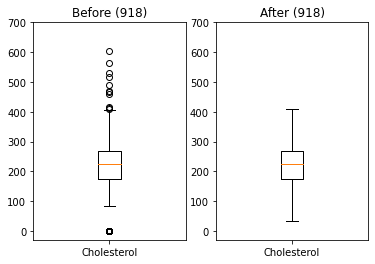

In [11]:
IQR = df['Cholesterol'].quantile(0.75) - df['Cholesterol'].quantile(0.25)

line_down = df['Cholesterol'].quantile(0.25) - IQR * 1.5
line_up = df['Cholesterol'].quantile(0.75) + IQR * 1.5

winsorized = df['Cholesterol'].clip(line_down, line_up)

fig, ax = plt.subplots(1, 2)
ax[0].boxplot(df['Cholesterol'], labels=['Cholesterol'])
ax[0].set_title("Before (%s)"%df['Cholesterol'].shape)
ax[0].set_ylim(-30, 700)

ax[1].boxplot(winsorized, labels=['Cholesterol'])
ax[1].set_title("After (%s)"%winsorized.shape)
ax[1].set_ylim(-30, 700)

plt.show()

### DBSCAN: -1로 구분되는 이상값들을 제거
밀도기반 클러스터링 기법 중 하나인 DBSCAN을 사용하여 데이터셋을 이상치와 나머지로 클러스터링


Scikit learn의 DBSCAN 함수를 사용

 0    667
-1     53
 1     16
 2     10
dtype: int64


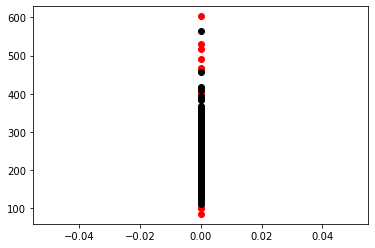

In [14]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
nonan = df['Cholesterol'].replace(0, np.nan).dropna()
# Cholesterol 값이 0인 관측치들은 결측치로 제거

dbscan = DBSCAN(eps=3, min_samples=10).fit(pd.DataFrame(nonan))
db_label = pd.Series(dbscan.labels_)
print(db_label.value_counts()) # -1이 이상치
dbdf = pd.DataFrame({'outlier':db_label, 'Chol':nonan})

for outlier, Chol in dbdf.values:
    if outlier == -1:
        plt.plot(0, Chol, 'o', color='red')
    else:
        plt.plot(0, Chol, 'o', color='black')